# 1 Finding Concurrent EMIT and NEON AOP Data

**Summary**  

The Earth surface Mineral dust source InvesTigation (EMIT) instrument is located on the International Space Station (ISS) and has collected data over a large area of the Continental US. The National Ecological Observatory Network (NEON) Airborne Observation Platform (AOP) collects aerial remote sensing data, including hyperspectral reflectance data over sites across the United States and Puerto Rico. In this notebook we will show how to utilize the [`earthaccess` Python library](https://github.com/nsidc/earthaccess) to find spatially overlapping EMIT and NEON reflectance data at NEON's [Niwot Ridge](https://www.neonscience.org/field-sites/niwo) site (NIWO) in Colorado - more specifically, in the Rocky Mountain Front Range.

<div>
<img src="./NEON_NIWO_EMIT_Concurrent_Data.PNG" width="750"/>
</div>

**Background**

The **EMIT** instrument is an imaging spectrometer that measures light in visible (V) to short-wave (SWIR) infrared wavelengths; this is also referred to as a VSWIR sensor. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. In addition, the EMIT instrument can be used in other applications, such as mapping of greenhouse gases, snow properties, and water resources.

More details about EMIT and its associated products can be found on the [EMIT website](https://earth.jpl.nasa.gov/emit/) and [EMIT product pages](https://lpdaac.usgs.gov/product_search/?query=EMIT&status=Operational&view=cards&sort=title) hosted by the LP DAAC.

The **NEON Imaging Spectrometer (NIS)** is an airborne [imaging spectrometer](https://www.neonscience.org/data-collection/imaging-spectrometer) built by JPL (AVIRIS-NG) and operated by the National Ecological Observatory Network's (NEON) Airborne Observation Platform (AOP). NEON's hyperspectral sensors collect measurements of sunlight reflected from the Earth's surface in 426 narrow (~5 nm) spectral channels spanning wavelengths between ~ 380 - 2500 nm. NEON's remote sensing data is intended to map and answer questions about a landscape, with ecological applications including identifying and classifying plant species and communities, mapping vegetation health, detecting disease or invasive species, and mapping droughts, wildfires, or other natural disturbances and their impacts. 

NEON surveys sites spanning the continental US, during peak phenological greenness, capturing each site 3 out of every 5 years, for most terrestrial sites. AOP's [Flight Schedules and Coverage](https://www.neonscience.org/data-collection/flight-schedules-coverage) provide's more information about the current and past schedules.

More detailed information about NEON's airborne sampling design can be found in the paper: [Spanning scales: The airborne spatial and temporal sampling design of the National Ecological Observatory Network](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.13942).

**Requirements**  
 - [NASA Earthdata Account](https://urs.earthdata.nasa.gov/home)   
 - *No Python setup requirements if connected to the workshop cloud instance!*  
 - **Local Only** Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder to set up a local compatible Python environment

 - NEON API Token (optional, but recommended), see [NEON API Tokens Tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial)

**Download the NEON Flight Boundary Shapefile:** <a href="https://www.neonscience.org/sites/default/files/AOP_flightBoxes_0.zip" class="link--button link--arrow">AOP_flightBoxes.zip</a>

**Learning Objectives**  
- Use functions provided in an external Python module to find and download available NEON airborne reflectance data.
- Use `earthaccess` to find EMIT data that overlaps with a NEON site.
- How to export a list of files and download them programmatically.  

**Tutorial Outline**  

1. Setup
2. Explore NEON sites and finding available NEON reflectance data
3. Search for EMIT reflectance data  
4. Organize and filter results
5. Visualize intersecting NEON-EMIT coverage
6. Create a list of EMIT asset URLs
7. Download EMIT data

## 1. Setup

Import the required Python libraries.

In [1]:
# Import required libraries
import os, sys
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math
import requests

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

### 1.2 NEON Data API and Python Functions

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [3]:
neon_code_folder = './neon_python_modules'
aop_download_module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_download_functions.py"
download_url(aop_download_module_url,neon_code_folder)
#os.listdir(neon_code_folder) #optionally show the contents of this directory to confirm the files downloaded

# add the code folder to the path and import the neon aop download functions module
sys.path.insert(0,neon_code_folder)
import neon_aop_download_functions as aop_dl;

### 1.3 NASA Earthdata Login Credentials

To download or stream NASA data you will need an Earthdata account, you can create one [here](https://urs.earthdata.nasa.gov/home). We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn't exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

## 2. Search for NEON and EMIT Data

NEON data products are hosted on the NEON Data Portal, and can be accessed via an API. We will import a Python module including some functions that interact with the NEON data API to easily see what data are available (in what years), and download data.

The EMIT products are hosted by the Land Processes Distributed Active Archive Center (LP DAAC). In this example we will use the cloud-hosted EMIT_L2A_RFL and ECOSTRESS_L2T_LSTE products available from the LP DAAC to find data. Any results we find for these products, should be available for other products within the EMIT and ECOSTRESS collections. 

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists of granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (ex: Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection). We can search using attributes such as collection, acquisition time, and spatial footprint. This process can also be used with other EMIT or ECOSTRESS products, other collections, or different data providers, as well as across multiple catalogs with some modification. 

### 2.1 Define Spatial Regions of Interest (ROIs)

For this example, our spatial region of interest (ROI) will be the NEON site [Niwot Ridge (NIWO)](https://www.neonscience.org/field-sites/niwo) in the Rocky Mountains, Colorado.

In this example, we will create a rectangular ROI surrounding the NIWO flight box. We will search for concurrent EMIT data using a polygon rather than a standard bounding box in `earthaccess`. To search for intersections with a polygon using earthaccess, we need to format our ROI as a counterclockwise list of coordinate pairs. 

Open the shape file (.shp) containing the AOP flight box boundaries, which can be downloaded from [NEON Spatial Data and Maps](https://www.neonscience.org/data-samples/data/spatial-data-maps). Read this into a `geodataframe`, explore the contents, and check the coordinate reference system (CRS) of the data.

In [4]:
username = os.getlogin() # get your username, this will be used when pointing to the download folder
aop_flightboxes = gpd.read_file(fr"C:\Users\{username}\Downloads\AOP_flightBoxes\AOP_flightboxesAllSites.shp")
aop_flightboxes.head()

domain domainName                                 siteName siteID  siteType  \
0    D01  Northeast        Bartlett Experimental Forest NEON   BART  Gradient   
1    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
2    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
3    D01  Northeast                     Lower Hop Brook NEON   HOPB      Core   
4    D19      Taiga                               Healy NEON   HEAL  Gradient   

    sampleType  priority  version         flightbxID  \
0  Terrestrial         1        1  D01_BART_R1_P1_v1   
1  Terrestrial         1        1  D01_HARV_C1_P1_v1   
2  Terrestrial         3        1  D01_HARV_C1_P3_v1   
3      Aquatic         2        1  D01_HOPB_C1_P2_v1   
4  Terrestrial         1        1  D19_HEAL_R3_P1_v1   

                                            geometry  
0  POLYGON ((-71.33426 43.99197, -71.33423 44.081...  
1  POLYGON ((-72.14819 42.57510, -72.14776 42.383...  
2  POLYGON ((-72.10812 42.43653, -72.14788 42.436...  
3  POLYGON ((-72.36635 42.46399, -72.36635 42.514...  
4  POLYGON ((-149.31505 63.82981, -149.31505 63.9...

In [5]:
aop_flightboxes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS is **EPSG:4326** (WGS84), which is also the CRS we want the data in to submit for our search of EMIT data.

Next, let's examine the AOP flightboxes polygons further. For this exercise, we'll first look at Niwot Ridge site in Colorado.

In [6]:
aop_flightboxes[aop_flightboxes.siteID == 'NIWO']

domain                           domainName          siteName siteID  \
49    D13  Southern Rockies & Colorado Plateau  Niwot Ridge NEON   NIWO   

   siteType   sampleType  priority  version         flightbxID  \
49     Core  Terrestrial         1        2  D13_NIWO_C1_P1_v2   

                                             geometry  
49  POLYGON ((-105.48908 40.07292, -105.48912 39.9...

We can see the NIWO `geodataframe` consists of a single polygon, that we want to include in our study site (sometimes NEON sites may have more than one polygon, as there are sometimes multiple areas, with different priorities for collection).

In [7]:
# write this to a new variable called "niwo_polygon"
niwo_polygon = aop_flightboxes[aop_flightboxes.siteID == 'NIWO']
# subset to only include columns of interest
niwo_polygon = niwo_polygon[['domain','siteName','siteID','sampleType','flightbxID','priority','geometry']]

In [8]:
# Create external boundary of the shape
niwo_roi_poly = niwo_polygon.unary_union.envelope
# Re-order vertices to counterclockwise
niwo_roi_poly = orient(niwo_roi_poly, sign=1.0)

Make a `GeoDataFrame` consisting of the bounding box geometry.

In [9]:
niwo_df = pd.DataFrame({"Name":["NIWO ROI Bounding Box"]})
niwo_bbox = gpd.GeoDataFrame({"Name":["NIWO ROI Bounding Box"], "geometry":[niwo_roi_poly]},crs="EPSG:4326")
niwo_bbox

Name                                           geometry
0  NIWO ROI Bounding Box  POLYGON ((-105.64789 39.98286, -105.48908 39.9...

We can write this bounding box to a `geojson` file for use in future notebooks. This is commented out for now, but you can uncomment and run the cell below, if desired.

In [ ]:
#niwo_bbox.to_file('../data/niwo_bbox.geojson', driver='GeoJSON')

Next we can visualize our region of interest and the exterior boundary polygon containing ROIs. First add a function to help reformat bounding box coordinates to work with leaflet notation.

In [10]:
# Function to convert a bounding box for use in leaflet notation
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [11]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox, name='bounding_box').add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                     popup=True,
                     categorical=True,
                     cmap='Set3',
                     style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                     name="Niwot Ridge ROI",
                     m=map1)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(niwo_polygon.unary_union.bounds))
display(fig)

Above we can see the Niwot Ridge flightbox, and the exterior boundary polygon containing the full area.

Lastly, we need to convert our polygon to a list of coordinate pairs, to create our Region of Interest (ROI).

In [12]:
# Set ROI as list of exterior polygon vertices as coordinate pairs
niwo_roi = list(niwo_roi_poly.exterior.coords)
niwo_roi

[(-105.64788824641289, 39.98286247719818),
 (-105.48907581013356, 39.98286247719818),
 (-105.48907581013356, 40.07295974374222),
 (-105.64788824641289, 40.07295974374222),
 (-105.64788824641289, 39.98286247719818)]

Finally we can look at the available NEON hyperspectral reflectance data over NIWO. NEON hyperspectral reflectance data are currently available under two different revisions, as AOP is in the process of implementing a BRDF (Bidirectional Reflectance Distribution Function), but this has not been applied to the full archive of data yet. These data are available under two revisions of the data product ID DP3.30006 - DP3.30006.001 are the directional surface reflectance, and DP3.30006.002 are the bidirectional (BRDF- and topographic- corrected) surface reflectance. Let's see what's available for each of these data products.

In [13]:
refl_rev1_dpid = 'DP3.30006.001'
refl_rev2_dpid = 'DP3.30006.002'
site = 'NIWO'

In [14]:
print('Directional Reflectance Data Available at NEON Site NIWO')
aop_dl.list_available_urls(refl_rev1_dpid,site)

Directional Reflectance Data Available at NEON Site NIWO


['https://data.neonscience.org/api/v0/data/DP3.30006.001/NIWO/2017-09',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/NIWO/2018-08',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/NIWO/2019-08',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/NIWO/2020-08']

In [15]:
print('Bidirectional Reflectance Data Available at NEON Site NIWO')
aop_dl.list_available_urls(refl_rev2_dpid,site)

Bidirectional Reflectance Data Available at NEON Site NIWO


The bidirectional data for the later visits of NIWO are not yet available. We'll start by looking at the directional surface reflectance for NIWO in 2020. 

In [16]:
year = '2020'

We can download the reflectance data using the function `aop_dl.download_aop_files`. You can change the download path if desired.

Before we download the data, let's look at the spatial extent. AOP data are provided in UTM projection. We can do this by downloading shapefiles of the tile boundaries. These are available as metadata provided along with the reflectance data products. The full boundary of the site is a file called "merged_tiles.shp/.shx". Let's only download this shapefile so we can see the file extent, and determine the UTM coordinates of the tiles we wish to download.

In [ ]:
# aop_dl.download_aop_files?

In [17]:
# download the full-boundary shape files from the lidar data. These are delivered as metadata as part of one of the Lidar data products, so note that the data product id (DPID) is different
aop_dl.download_aop_files('DP1.30003.001',site,year,'./data/neon_refl',match_string='merged_tiles.shp',check_size=False)
aop_dl.download_aop_files('DP1.30003.001',site,year,'./data/neon_refl',match_string='merged_tiles.shx',check_size=False)

Download size: 0.61 kB
downloading 2020_NIWO_4_merged_tiles.shp to ./data/neon_refl
Download size: 0.0 kB
downloading 2020_NIWO_4_merged_tiles.shx to ./data/neon_refl


In [18]:
# optionally display the contents in the data/neon_refl folder to make sure the files have downloaded
os.listdir('./data/neon_refl')

['2020_NIWO_4_merged_tiles.shp', '2020_NIWO_4_merged_tiles.shx']

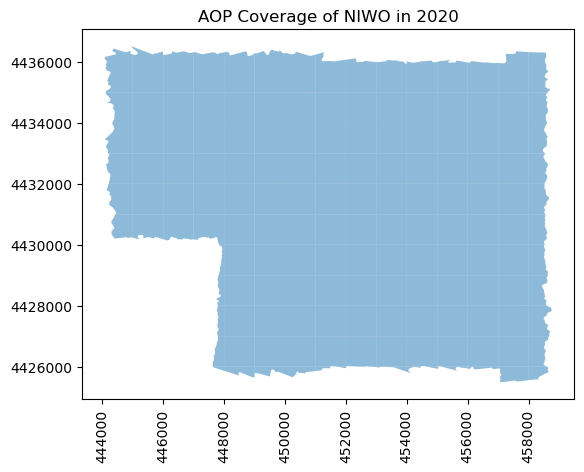

In [19]:
niwo_2020_gdf = gpd.read_file(os.path.join('./data/neon_refl','2020_NIWO_4_merged_tiles.shp'))
niwo_2020_gdf.plot(alpha=0.5);
ax = plt.gca(); ax.ticklabel_format(style='plain') 
ax.set_title('AOP Coverage of ' + site + ' in ' + year);
plt.xticks(rotation=90); #optionally rotate the xtick labels

The reflectance data can be large in size, so for now, we'll just download a single tile, which encompasses the CU Boulder Mountain Research Station at Niwot Ridge. We can do that with the `download_aop_files` function as follows. This time leave out the `check_size` input parameter, and that will default to True. This will prompt you to download after displaying the download size. This reflectance file is ~615 MB, so make sure you have enough space on your local disk before downloading.

In [ ]:
# download a reflectance hdf5 tile
aop_dl.download_aop_files('DP3.30006.001',site,year,'./data/neon_refl',match_string='454000_4431000_reflectance.h5')

### 2.2 Define EMIT Collections of Interest
We need to specify which products we want to search for. The best way to do this is using their concept-id. As mentioned above, we will conduct our search using the EMIT Level 2A Reflectance (EMITL2ARFL). We can do some quick collection queries using `earthaccess` to retrieve the concept-id for each dataset. 

In [20]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2A Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2408750690-LPCLOUD",
     "granule-count": 84319,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2ARFL",
     "EntryTitle": "EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001",
     "Version": "001"
   }
 }]

If your search returns multiple products, be sure to select the right concept-id For this example it will be the first one. We want to use the `LPCLOUD` ECOSTRESS Tiled Land Surface Temperature and Emissivity (concept-id: "C2076090826-LPCLOUD"). Create a list of these concept-ids for our data search.

In [21]:
# Data Collections for our search
emit_concept_id = ['C2408750690-LPCLOUD']

### 2.3 Define Date Range

For our date range, we'll look at data collected between January 2022 and October 2023. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [22]:
# Define Date Range
date_range = ('2022-01-01','2023-11-01')

### 2.4 Searching

Submit a query using `earthaccess`, usin the `niwo_roi` as the region of interest.

In [23]:
emit_query_results = earthaccess.search_data(
    concept_id=emit_concept_id,
    polygon=niwo_roi,
    temporal=date_range,
    count=500)

Granules found: 15



## 3. Organizing and Filtering Results

As we can see from above, the results object contains a list of objects with metadata and links. We can convert this to a more readable format, a dataframe. In addition, we can make it a geodataframe by taking the spatial metadata and creating a shapely polygon representing the spatial coverage, and further customize which information we want to use from other metadata fields.

First, we define some functions to help us create a shapely object for our geodataframe, and retrieve the specific browse image URLs that we want. By default, the browse image selected by `earthaccess` is the first one in the list, but the ECO_L2_LSTE has several browse images, and we want to make sure we retrieve the `png` file, which is a preview of the LSTE.

In [24]:
# Function to create shapely polygon of spatial coverage
def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

Now that we have our functions we can create a dataframe, then calculate and add our shapely geometries to make a geodataframe. After that, add a column for our browse image urls and print the number of granules in our results, so we can monitor the quantity we  are working with a we winnow down to the data we want.

In [25]:
# Create Dataframe of Results Metadata
emit_results_df = pd.json_normalize(emit_query_results)
# Create shapely polygons for result
geometries = [get_shapely_object(emit_query_results[index]) for index in emit_results_df.index.to_list()]
# Convert to GeoDataframe
emit_gdf = gpd.GeoDataFrame(emit_results_df, geometry=geometries, crs="EPSG:4326")
# Remove emit_results_df, no longer needed
del emit_results_df
# Add browse imagery links
emit_gdf['browse'] = [get_png(granule) for granule in emit_query_results]
emit_gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in emit_query_results]
# Preview GeoDataframe
print(f'{emit_gdf.shape[0]} granules total')

15 granules total


Preview our geodataframe to get an idea what it looks like.

In [26]:
emit_gdf.head()

size meta.concept-type      meta.concept-id  meta.revision-id  \
0  3578.655884           granule  G2597398990-LPCLOUD                 1   
1  3581.975898           granule  G2597690501-LPCLOUD                 1   
2  3580.405610           granule  G2624104672-LPCLOUD                 1   
3  3578.689785           granule  G2646169485-LPCLOUD                 1   
4  3577.591364           granule  G2646169234-LPCLOUD                 1   

                                 meta.native-id meta.collection-concept-id  \
0  EMIT_L2A_RFL_001_20220816T210039_2222814_001        C2408750690-LPCLOUD   
1  EMIT_L2A_RFL_001_20220820T192256_2223213_003        C2408750690-LPCLOUD   
2  EMIT_L2A_RFL_001_20230203T185001_2303413_010        C2408750690-LPCLOUD   
3  EMIT_L2A_RFL_001_20230329T212754_2308814_017        C2408750690-LPCLOUD   
4  EMIT_L2A_RFL_001_20230329T212806_2308814_018        C2408750690-LPCLOUD   

  meta.provider-id                        meta.format  \
0          LPCLOUD  application/vnd.nasa.cmr.umm+json   
1          LPCLOUD  application/vnd.nasa.cmr.umm+json   
2          LPCLOUD  application/vnd.nasa.cmr.umm+json   
3          LPCLOUD  application/vnd.nasa.cmr.umm+json   
4          LPCLOUD  application/vnd.nasa.cmr.umm+json   

         meta.revision-date  \
0  2023-01-27T10:36:41.872Z   
1  2023-01-28T00:54:23.821Z   
2  2023-03-02T03:11:43.968Z   
3  2023-04-02T02:42:57.159Z   
4  2023-04-02T02:42:41.276Z   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  ...  \
0                               2022-08-16T21:00:39Z  ...   
1                               2022-08-20T19:22:56Z  ...   
2                               2023-02-03T18:50:01Z  ...   
3                               2023-03-29T21:27:54Z  ...   
4                               2023-03-29T21:28:06Z  ...   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

   umm.DataGranule.ArchiveAndDistributionInformation  \
0  [{'Name': 'EMIT_L2A_RFL_001_20220816T210039_22...   
1  [{'Name': 'EMIT_L2A_RFL_001_20220820T192256_22...   
2  [{'Name': 'EMIT_L2A_RFL_001_20230203T185001_23...   
3  [{'Name': 'EMIT_L2A_RFL_001_20230329T212754_23...   
4  [{'Name': 'EMIT_L2A_RFL_001_20230329T212806_23...   

  umm.DataGranule.ProductionDateTime  \
0               2023-01-27T10:26:44Z   
1               2023-01-28T00:42:40Z   
2               2023-03-02T03:01:34Z   
3               2023-04-02T02:32:39Z   
4               2023-04-02T02:32:39Z   

                                       umm.Platforms  \
0  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
1  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
2  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
3  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
4  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   

                       umm.MetadataSpecification.URL  \
0  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
1  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
2  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
3  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
4  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   

  umm.MetadataSpecification.Name umm.MetadataSpecification.Version  \
0                          UMM-G                             1.6.6   
1                          UMM-G                             1.6.6   
2                          UMM-G                             1.6.6   
3                          UMM-G                             1.6.6   
4                          UMM-G                             1.6.6   

                                            geometry  \
0  POLYGON ((-105.64632 40.42052, -106.05467 39.7...   
1  POLYGON ((-105.71240 41.02232, -106.10945 40.3...   
2  POLYGON ((-105.33098 40.69196, -106.29222 40.1...   
3  POLYGON ((-105.67938 40.79424, -106.64290 40.2...   
4  POLYGON ((-104.90044 41.24032, -

There are a lot of columns with data that is not relevant for this exercise, so we can drop those. To do that, list the names of columns.

In [27]:
# List Column Names
emit_gdf.columns

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'geometry', 'browse', 'shortname'],
      dtype='object')

Now create a list of columns to keep and use it to filter the dataframe.

In [28]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
emit_gdf = emit_gdf[emit_gdf.columns.intersection(keep_cols)]
emit_gdf.head()

meta.concept-id                                meta.native-id  \
0  G2597398990-LPCLOUD  EMIT_L2A_RFL_001_20220816T210039_2222814_001   
1  G2597690501-LPCLOUD  EMIT_L2A_RFL_001_20220820T192256_2223213_003   
2  G2624104672-LPCLOUD  EMIT_L2A_RFL_001_20230203T185001_2303413_010   
3  G2646169485-LPCLOUD  EMIT_L2A_RFL_001_20230329T212754_2308814_017   
4  G2646169234-LPCLOUD  EMIT_L2A_RFL_001_20230329T212806_2308814_018   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  \
0                               2022-08-16T21:00:39Z   
1                               2022-08-20T19:22:56Z   
2                               2023-02-03T18:50:01Z   
3                               2023-03-29T21:27:54Z   
4                               2023-03-29T21:28:06Z   

  umm.TemporalExtent.RangeDateTime.EndingDateTime  umm.CloudCover  \
0                            2022-08-16T21:00:51Z              98   
1                            2022-08-20T19:23:08Z              85   
2                            2023-02-03T18:50:13Z              95   
3                            2023-03-29T21:28:06Z             100   
4                            2023-03-29T21:28:17Z              96   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

                                            geometry  \
0  POLYGON ((-105.64632 40.42052, -106.05467 39.7...   
1  POLYGON ((-105.71240 41.02232, -106.10945 40.3...   
2  POLYGON ((-105.33098 40.69196, -106.29222 40.1...   
3  POLYGON ((-105.67938 40.79424, -106.64290 40.2...   
4  POLYGON ((-104.90044 41.24032, -105.88304 40.6...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL

This is looking better, but we can make it more readable by renaming our columns.

In [29]:
# Rename some Columns
emit_gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                           'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                           'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                           'umm.CloudCover':'cloud_cover',
                           'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
emit_gdf.head()

concept_id                                       granule  \
0  G2597398990-LPCLOUD  EMIT_L2A_RFL_001_20220816T210039_2222814_001   
1  G2597690501-LPCLOUD  EMIT_L2A_RFL_001_20220820T192256_2223213_003   
2  G2624104672-LPCLOUD  EMIT_L2A_RFL_001_20230203T185001_2303413_010   
3  G2646169485-LPCLOUD  EMIT_L2A_RFL_001_20230329T212754_2308814_017   
4  G2646169234-LPCLOUD  EMIT_L2A_RFL_001_20230329T212806_2308814_018   

         start_datetime          end_datetime  cloud_cover day_night  \
0  2022-08-16T21:00:39Z  2022-08-16T21:00:51Z           98       Day   
1  2022-08-20T19:22:56Z  2022-08-20T19:23:08Z           85       Day   
2  2023-02-03T18:50:01Z  2023-02-03T18:50:13Z           95       Day   
3  2023-03-29T21:27:54Z  2023-03-29T21:28:06Z          100       Day   
4  2023-03-29T21:28:06Z  2023-03-29T21:28:17Z           96       Day   

                                            geometry  \
0  POLYGON ((-105.64632 40.42052, -106.05467 39.7...   
1  POLYGON ((-105.71240 41.02232, -106.10945 40.3...   
2  POLYGON ((-105.33098 40.69196, -106.29222 40.1...   
3  POLYGON ((-105.67938 40.79424, -106.64290 40.2...   
4  POLYGON ((-104.90044 41.24032, -105.88304 40.6...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL

> **Note: If querying on-premises (not cloud) LP DAAC datasets, the `meta.concept-id` will not show as `xxxxxx-LPCLOUD`. For these datasets, the granule name can be retrieved from the `umm.DataGranule.Identifiers` column.**

We can filter using the day/night flag as well, since we need a daytime collection to be comparable to the NEON data (which is captured at a high solar angle).

In [ ]:
# emit_gdf = emit_gdf[emit_gdf['day_night'].str.contains('Day')]

Our first step toward filtering the datasets will be to add a column with a `datetime`. 

> **You may have noticed that the date format is similar for ECOSTRESS and EMIT, but the ECOSTRESS data also includes fractional seconds. If working locally using `lpdaac_vitals` python environment, you may need to pass the `format='ISO8601'`argument to the `to_datetime` function, as shown in the commented-out line due to a difference in versions of pandas.**

In [30]:
#emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime']) # 2i2c
emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime'], format='ISO8601') # Local ENV

We can roughly visualize the quantity of results by month at our location using a histogram with 8 bins (Jan - Oct).

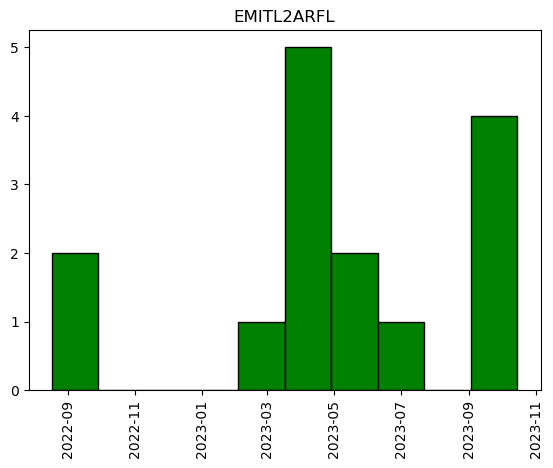

In [31]:
emit_gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True);


## 4. Visualizing Intersecting Coverage

Now that we have geodataframes containing some concurrent data, we can visualize them on a map using `folium`. It's often difficult to visualize a large time-series of scenes, so we've included an example in Appendix A1 on how to filter to a single day.

In [32]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox,
                name='bounding_box',).add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="Niwot Ridge ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

### 4.2 Previewing EMIT Browse Imagery
The EMIT browse imagery is not orthorectified, so to get an idea what scenes look like, we can plot them in a grid using matplotlib.

> Note: The black space is indicative of onboard cloud masking that occurs before data is downlinked from the ISS.

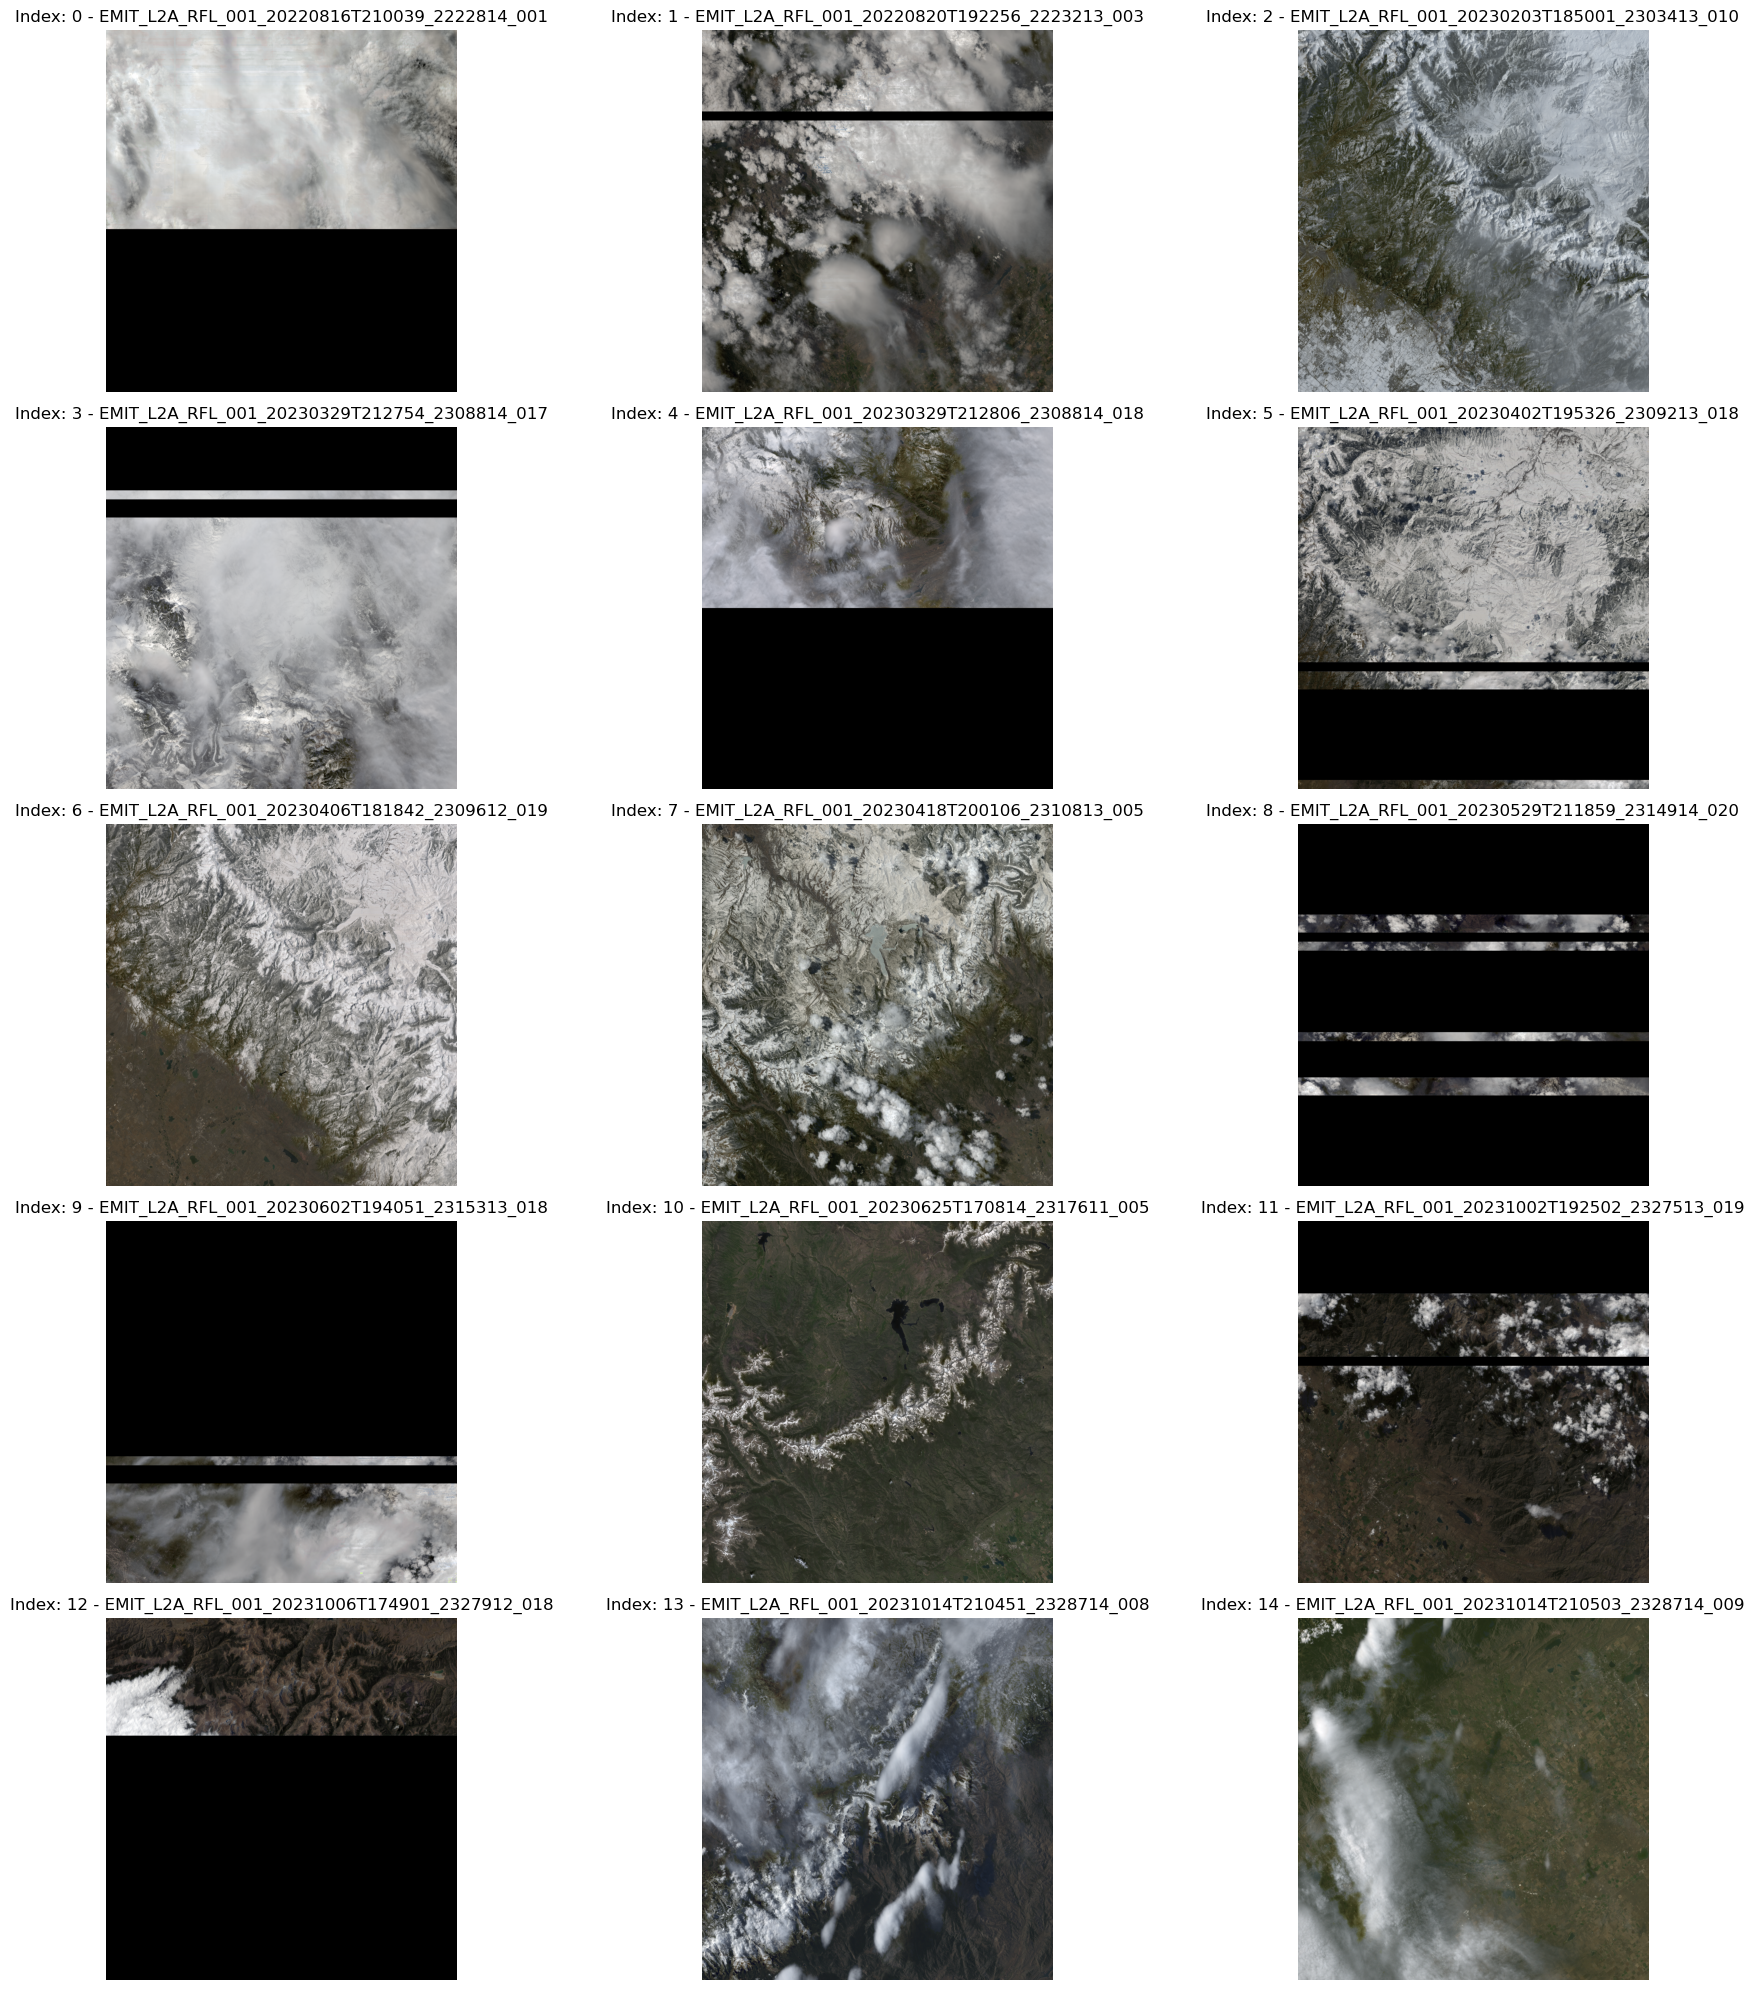

In [33]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

### 4.3 Further Filtering

We can see that some of these granules likely won't work because of the large amount of cloud cover, we can use a list of these to filter them out. Make a list of indexes to filter out.

Filter out the bad granules.

In [34]:
# set a threshold for cloud cover and filter to remove scenes with >50% cloud cover
emit_gdf_clear = emit_gdf[emit_gdf.cloud_cover < 50]

In [35]:
emit_gdf_clear

concept_id                                       granule  \
10  G2736967625-LPCLOUD  EMIT_L2A_RFL_001_20230625T170814_2317611_005   

          start_datetime          end_datetime  cloud_cover day_night  \
10  2023-06-25T17:08:14Z  2023-06-25T17:08:26Z            8       Day   

                                             geometry  \
10  POLYGON ((-105.92612 40.60380, -106.33020 39.9...   

                                               browse   shortname  \
10  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   

                datetime_obj  
10 2023-06-25 17:08:14+00:00

We can see that there is only one scene with <50% cloud cover. Luckily, this is captured in late June (June 25), which is close in time to when NEON typically surveys Niwot Ridge. NEON surveys during "peak-greenness", when leaves are most photosynthetically active, which at NIWO usually occurs in July - August (in 2020 NIWO was surveyed on July 20, July 31, August 1, and August 7), in 2023 NIWO was surveyed on July 24, August 15, and August 21). Data from 2023 are not yet available from NEON.

Let's take a look at the clear-weather EMIT dataset (Index 10):

- **10**: `EMIT_L2A_RFL_001_20230625T170814_2317611_005`

We can plot this scene as follows:

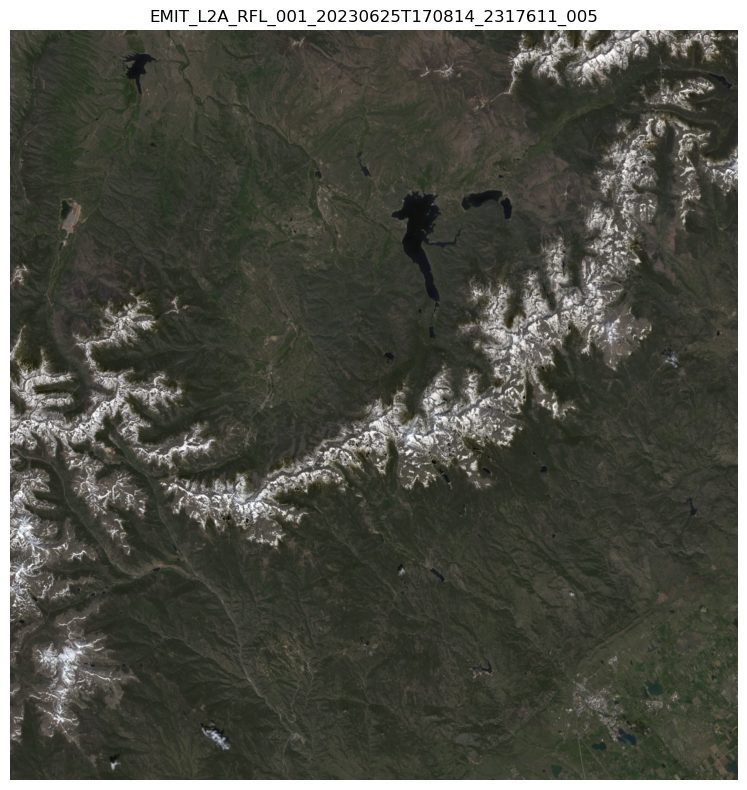

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
img = io.imread(emit_gdf_clear['browse'][10])
ax.imshow(img)
ax.set_title(f"{emit_gdf_clear['granule'][10]}")
ax.axis('off')
plt.tight_layout()
plt.show()

**We can now go back to our `folium` plot above and  re-run the cell to update it based on our filtering.**

In [37]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox,
                name='bounding_box',
                ).add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="Niwot Ridge ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf_clear.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)


## 5. Generating a list of URLs and downloading data

Creating a list of results URLs will include all of these assets, so if we only want a subset we need an additional filter to keep the specific assets we want.

If you look back, you can see we kept the same indexing throughout the notebook. This enables us to simply subset the `earthaccess` results object to retrieve the results we want. 

Create a list of index values to keep.

In [38]:
keep_granules = [10]

Filter the results list.

In [39]:
filtered_results = [result for i, result in enumerate(emit_query_results) if i in keep_granules]

Now we can download all of the associated assets, or retrieve the URLS and further filter them to specifically what we want. 

First, log into Earthdata using the `login` function from the `earthaccess` library. The `persist=True` argument will create a local `.netrc` file if it doesn't exist, or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. As mentioned in section 1.2, this step is not necessary to conduct searches, but is needed to download or stream data.

Now we can download all assets using the following cell.

In [ ]:
# Download All Assets for Granules in Filtered Results
#earthaccess.download(filtered_results, '../data/NIWO/emit_refl')

Or we can create a list of URLs and use that to further refine which files we download.

In [40]:
# Retrieve URLS for Assets
results_urls = [granule.data_links() for granule in filtered_results]

In [41]:
results_urls

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFLUNCERT_001_20230625T170814_2317611_005.nc',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_MASK_001_20230625T170814_2317611_005.nc']]

We can see this is a nested list. Granules often have several assets associated with them, for example, `EMIT_L2A` has several assets:

- RFL
- RFLUNCERT
- MASK
  
The results list we just generated contains URLs to all of these assets nested by granule. We can further filter our results list using string matching to remove unwanted assets.

Create a list of strings and enumerate through our results_url list to filter out unwanted assets and remove the nesting.

In [42]:
filtered_asset_links = []
# Pick Desired Assets (leave _ on RFL to distinguish from RFLUNC, LST. to distinguish from LST_err)
desired_assets = ['RFL_','MASK', 'LST.'] # Add more or do individually for reflectance, reflectance uncertainty, or mask
# Step through each sublist (granule) and filter based on desired assets.
for n, granule in enumerate(results_urls):
    for url in granule: 
        asset_name = url.split('/')[-1]
        if any(asset in asset_name for asset in desired_assets):
            filtered_asset_links.append(url)
filtered_asset_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_MASK_001_20230625T170814_2317611_005.nc']

We can see that this removed the `REFLUNCERT` data. We can also write this list of files to a text file to have a record of data used, or stream the data using `https` as we access them. For streaming the data, the EMIT files are very large, so operations can take some time.

In [43]:
with open('./data/emit_search_results.txt', 'w') as f:
    for line in filtered_asset_links:
        f.write(f"{line}\n")

This list of files is rather long and downloading all of them requires around 20gb of storage. We've included the canopy water content files in the repository to reduce storage requirements and computation time. Only 3 granules are required to execute the notebooks and walk through the notebooks in the repository. 

Open the list of required granules.

>Note: You can download all of the files using the cell below and recreate all of the canopy water content files following a workflow similar to the example in notebooks 2 and 3 for all of the necessary scenes. To do this, uncomment the `file_list` object with the `emit_search_results.txt` filepath to download all of the results rather than just what is required.

In [44]:
# Open Text File and Read Lines
#file_list = './data/required_granules.txt'
file_list = './data/emit_search_results.txt'
with open(file_list) as f:
    urls = [line.rstrip('\n') for line in f]

Download the required granules.

In [ ]:
# Get requests https session using Earthdata Login Info
fs = earthaccess.get_requests_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
for url in urls:
    granule_asset_id = url.split('/')[-1]
    # Define Local Filepath
    fp = f'./data/emit_refl/{granule_asset_id}'
    # Download the Granule Asset if it doesn't exist
    if not os.path.isfile(fp):
        with fs.get(url,stream=True) as src:
            with open(fp,'wb') as dst:
                for chunk in src.iter_content(chunk_size=64*1024*1024):
                    dst.write(chunk)

Congratulations, now you have downloaded concurrent hyperspectral reflectance data from NEON airborne collections and the EMIT instrument on the ISS.

## Contact Info:  

**LPDAAC**

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 01-23-2024  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 

**NEON**

Organization: Airborne Observation Platform
Website: <https://www.neonscience.org/>   
Contact: <https://www.neonscience.org/about/contact-us>   
Date last modified: 04-29-2024 